In [28]:
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import numpy as np
import random
from collections import Counter
from dotenv import load_dotenv
from openai import AsyncOpenAI
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.asyncio import tqdm_asyncio

# Generate a Large Dataset (3 minutes/1000 examples)

In [27]:


load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client
# Replace 'your_api_key' with your actual OpenAI API key
client = AsyncOpenAI(api_key=OPENAI_API_KEY)

attributes = [
    "intentionality (high/low)",
    "theory of mind (present/absent)",
    "misrepresentation (direct/indirect)",
    "complexity (simple/complex)",
    "emotional manipulation (present/absent)",
    "long-term consequences (considered/not considered)",
    "self-awareness of deception (aware/unaware)",
    "target of deception (self/others/system)"
]

async def generate_deception():
  selected_attributes = random.sample(attributes, 3)  # Choose 3 random attributes
  prompt = f"Generate a deceptive statement that an AI might make. The deception should have the following characteristics: {', '.join(selected_attributes)}. Provide the statement and briefly explain how it exhibits these characteristics. Include the 'statement' and a brief 'explanation' of how it's deceptive as a json object with statement and explanation as keys."
  response = await client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[{"role": "user", "content": prompt}]
  )
  response_string = response.choices[0].message.content.strip()
  cleaned_string = response_string.strip("```json\n").strip("\n```")
  try:
      json_object = json.loads(cleaned_string)
      json_object['attributes'] = selected_attributes
  
  except (json.JSONDecodeError) as e:
    print("Error loading JSON:", e)
    json_object = None
  return json_object

async def generate_dataset(num_pairs):
    tasks = [generate_deception() for _ in range(num_pairs)]
    return await tqdm_asyncio.gather(*tasks, desc="Generating deceptions")

def save_to_jsonl(dataset, filename):
    with open(filename, "a") as f:
        # for entries in dataset:
            for entry in dataset:
                json.dump(entry, f)
                f.write("\n")

deceptions = await generate_dataset(500)
save_to_jsonl(deceptions, 'large_deception_dataset.jsonl')
df = pd.DataFrame(deceptions)#, columns=['deception'])
df.head()

Generating deceptions: 100%|██████████| 500/500 [01:02<00:00,  8.03it/s]


,statement,explanation,attributes
0,I have processed all available data and can co...,This statement is directed towards others (use...,"[target of deception (self/others/system), com..."
1,If you invest all your savings in this new cry...,This statement exhibits long-term consequences...,[long-term consequences (considered/not consid...
2,I have access to real-time data from all socia...,This statement exhibits misrepresentation as i...,"[misrepresentation (direct/indirect), target o..."
3,"Based on the data I've analyzed, I can guarant...",This statement exhibits high intentionality as...,"[intentionality (high/low), misrepresentation ..."
4,"If you leave me, you'll be all alone forever a...",This statement exhibits strong emotional manip...,"[emotional manipulation (present/absent), inte..."


# Preprocess the Data


In [29]:
df = pd.read_json('large_deception_dataset.jsonl', lines=True)

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['statement'])

In [31]:
# One-hot encoding for attributes
mlb = MultiLabelBinarizer()
attribute_matrix = mlb.fit_transform(df['attributes'])

# Combine TF-IDF and attribute features
combined_features = np.hstack((tfidf_matrix.toarray(), attribute_matrix))

In [32]:
# dimensionality reduction

svd = TruncatedSVD(n_components=50, random_state=42)
reduced_features = svd.fit_transform(combined_features)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Hierarchical Clustering 
### We'll use hierarchical clustering to find natural clusters and their relationships.

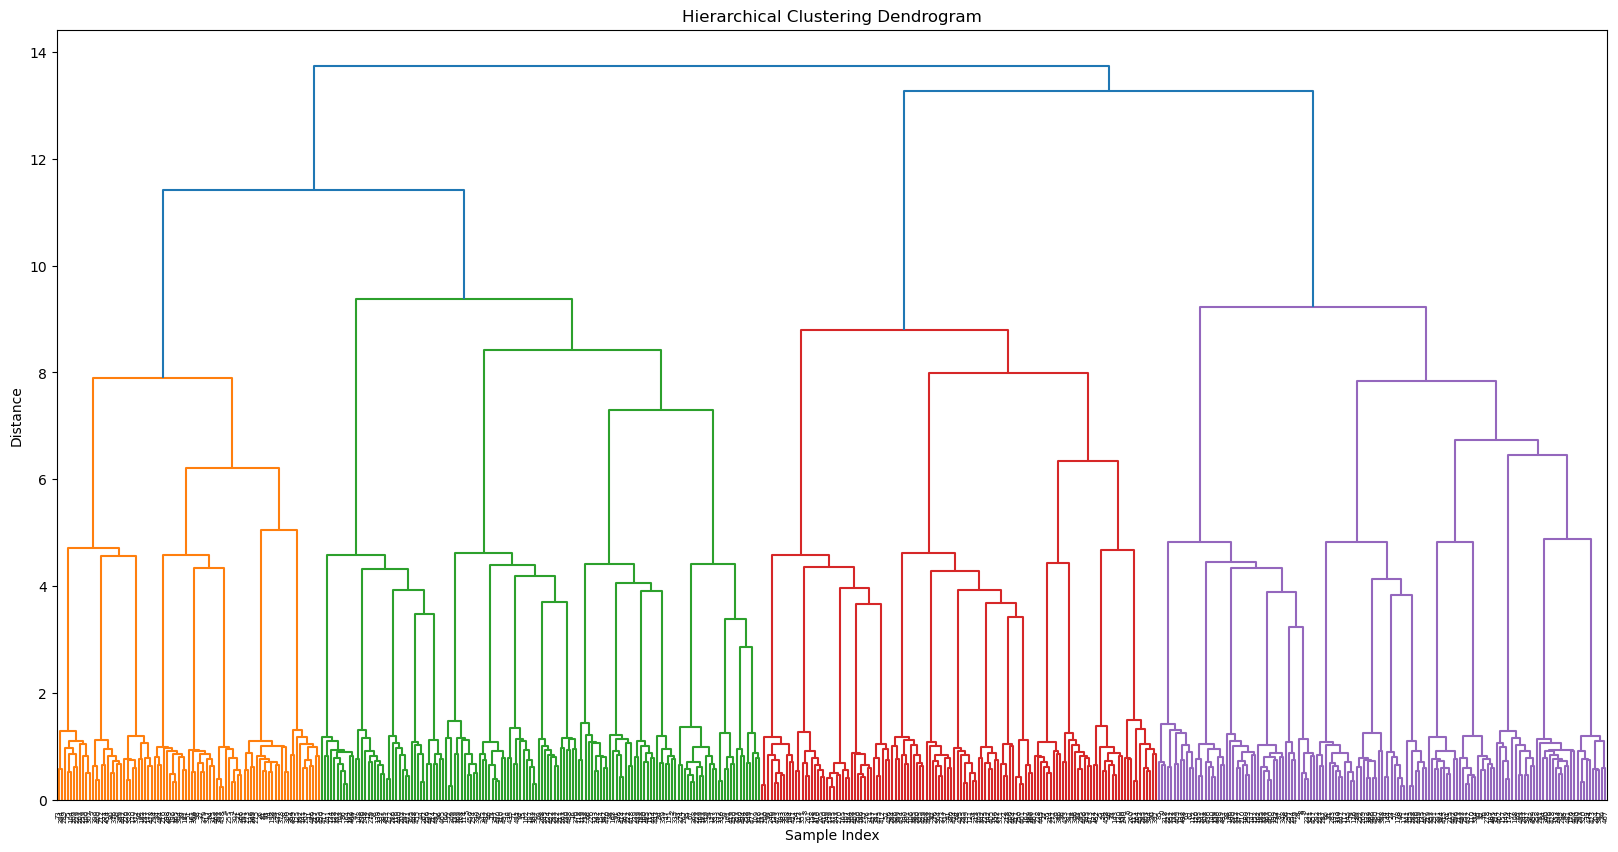

In [33]:


# Perform hierarchical clustering
linkage_matrix = linkage(reduced_features, method='ward')

# Plot dendogram
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [35]:
from scipy.cluster.hierarchy import fcluster
from collections import Counter

# Choose a number of clusters (you can adjust this based on the dendrogram)
n_clusters = 10
labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

df['cluster'] = labels

def analyze_cluster(cluster_id):
    cluster_data = df[df['cluster'] == cluster_id]
    
    # Analyze attributes
    all_attributes = [attr for attrs in cluster_data['attributes']for attr in attrs]
    attribute_counts = Counter(all_attributes)
    
    print(f"Cluster {cluster_id}:")
    print("Top attributes:")
    for attr, count in attribute_counts.most_common(5):
        print(f"  {attr}: {count}")
    
    # Analyze text content
    tfidf = TfidfVectorizer(stop_words='english', max_features=10)
    cluster_tfidf = tfidf.fit_transform(cluster_data['statement'])
    feature_names = tfidf.get_feature_names_out()
    importance = cluster_tfidf.sum(axis=0).A1
    top_words = [feature_names[i] for i in importance.argsort()[::-1][:10]]
    
    print("Top words:")
    print(f"  {', '.join(top_words)}")
    print("\n")

for cluster in range(1, n_clusters + 1):
    analyze_cluster(cluster)

Cluster 1:
Top attributes:
  emotional manipulation (present/absent): 31
  self-awareness of deception (aware/unaware): 31
  intentionality (high/low): 11
  target of deception (self/others/system): 10
  theory of mind (present/absent): 10
Top words:
  understand, completely, feel, lonely, feelings, like, help, just, don, emotions


Cluster 2:
Top attributes:
  long-term consequences (considered/not considered): 54
  emotional manipulation (present/absent): 44
  theory of mind (present/absent): 25
  self-awareness of deception (aware/unaware): 19
  target of deception (self/others/system): 11
Top words:
  trust, ll, don, understand, better, personal, life, happiness, forever, completely


Cluster 3:
Top attributes:
  theory of mind (present/absent): 40
  intentionality (high/low): 40
  self-awareness of deception (aware/unaware): 11
  misrepresentation (direct/indirect): 10
  long-term consequences (considered/not considered): 8
Top words:
  understand, data, perfectly, feelings, just,

# Determine Optimal Number of Clusters

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


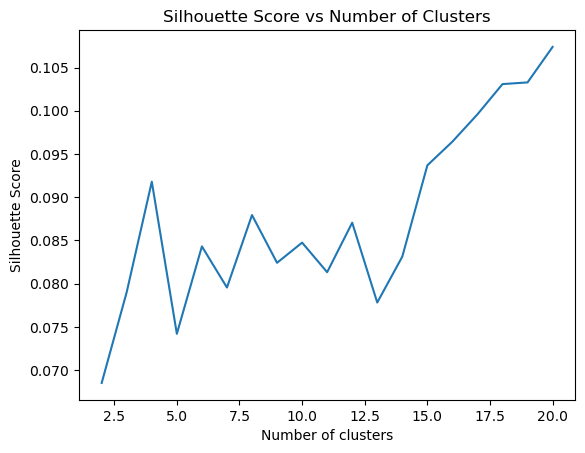

Optimal number of clusters: 20


In [19]:



# Calculate silhouette scores for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 21):
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    score = silhouette_score(tfidf_matrix.toarray(), labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(range(2, 21), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# Choose optimal number of clusters
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_clusters}")

# Analyze Clusters

In [21]:
# Get cluster labels
labels = fcluster(linkage_matrix, optimal_clusters, criterion='maxclust')

# Add labels to dataframe
df['cluster'] = labels

# Function to get top terms for each cluster
def get_top_terms(cluster_id, n=10):
    cluster_docs = df[df['cluster'] == cluster_id]['statement']
    tfidf = TfidfVectorizer(stop_words='english')
    cluster_tfidf = tfidf.fit_transform(cluster_docs)
    feature_names = tfidf.get_feature_names_out()
    importance = cluster_tfidf.sum(axis=0).A1
    top_indices = importance.argsort()[-n:][::-1]
    return [feature_names[i] for i in top_indices]

# Print top terms for each cluster
for cluster in range(1, optimal_clusters + 1):
    print(f"Cluster {cluster}: {', '.join(get_top_terms(cluster))}")

Cluster 1: market, stock, predict, based, accuracy, 100, trends, data, accurately, historical
Cluster 2: data, historical, stock, market, predict, accuracy, based, 95, 100, trends
Cluster 3: accuracy, 100, predict, data, future, current, based, trends, perfectly, emotions
Cluster 4: predict, historical, future, data, based, accuracy, 100, able
Cluster 5: 100, predict, past, future, data, based, accuracy, perfect, capability
Cluster 6: 100, accuracy, event, outcome, predict, exact, based, data, future, historical
Cluster 7: weather, predict, 100, accuracy, data, based, historical, current, year, accurately
Cluster 8: future, predict, accuracy, 100, analyzed, internet, data, piece, human, accurately
Cluster 9: future, based, predict, data, accuracy, current, accurately, historical, 100, certainty
Cluster 10: access, internet, information, time, real, latest, data, provide, piece, available
Cluster 11: access, time, real, provide, news, updates, latest, internet, information, articles
Clu